In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Tensorflow & Keras
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from keras.utils import to_categorical
from math import ceil
from tensorflow.keras.layers import Input,MaxPooling2D, GlobalAveragePooling2D, Conv2D, Concatenate, BatchNormalization, DepthwiseConv2D, Lambda, Reshape, Layer, Activation, add
from keras_layer_normalization import LayerNormalization
import math
from keras.callbacks import Callback

import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


# 1. Data Exploration

In [2]:
import IPython.display as ipd
fname = './dataset/B_ANI01_MC_FN_SIM01_101.wav'
ipd.Audio(fname)

Text(0.5, 1.0, 'Butler frog waveform')

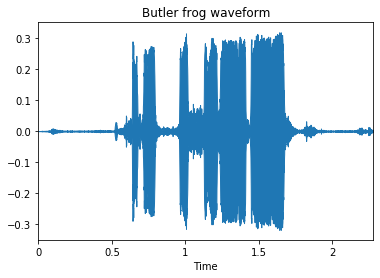

In [3]:
import librosa
import librosa.display
y, sr = librosa.load(fname)
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Butler frog waveform')

# 2. Data Preprocess
## 2.1 Prepare train data & test data  as Pandas

In [4]:
file_list = []
label_list = []
for i in os.listdir('./dataset'):
    file_list.append(i)
    label_list.append(i.split('_')[2])

In [5]:
file_list[0]

'B_ANI01_MC_FN_SIM01_101.wav'

In [6]:
from pandas.core.frame import DataFrame
train= pd.DataFrame({'fname':file_list})
train.head(3)

,fname
0,B_ANI01_MC_FN_SIM01_101.wav
1,B_ANI01_MC_FN_SIM01_102.wav
2,B_ANI01_MC_FN_SIM01_103.wav


## 2.2 Prepare length of sound

In [7]:
from pydub import AudioSegment

D:\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [8]:
file = file_list[0]
path = './dataset/'

import wave

def get_length(file):
    audio = wave.open(path+file)
    return audio.getnframes() / audio.getframerate()

get_length(file)

2.2815

In [9]:
from joblib import Parallel, delayed

with Parallel(n_jobs=10, verbose=1) as ex:
    lengths = ex(delayed(get_length)(e) for e in train.fname)
    
train['length'] = lengths    
train.head()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 400 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done 440 out of 440 | elapsed:    4.1s finished


,fname,length
0,B_ANI01_MC_FN_SIM01_101.wav,2.281500
1,B_ANI01_MC_FN_SIM01_102.wav,1.419000
2,B_ANI01_MC_FN_SIM01_103.wav,1.798875
3,B_ANI01_MC_FN_SIM01_301.wav,1.739500
4,B_ANI01_MC_FN_SIM01_302.wav,1.268000


In [10]:
train.shape

(440, 2)

In [11]:
train.describe()

,length
count,440.000000
mean,1.831099
std,0.361251
min,1.085500
25%,1.635219
50%,1.809562
75%,1.981500
max,4.001500


# 3. Feature Extraction
## 3.1 MFCC (Mel-Frequency Cepstral Coefficients)

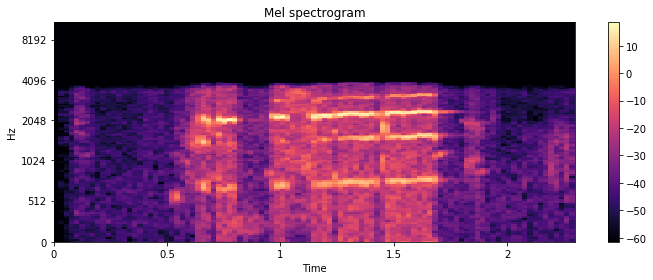

In [12]:
melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)
logmelspec = librosa.power_to_db(melspec) 
plt.figure(figsize=(10, 4))
librosa.display.specshow(logmelspec,y_axis='mel', x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

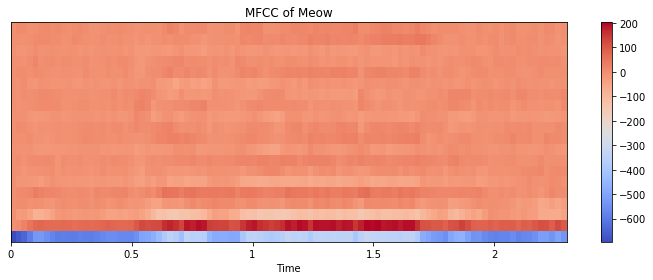

In [13]:
# Visualize the MFCC series
mfccs = librosa.feature.mfcc(y, sr, n_fft=1024, hop_length=512, n_mels=128)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC of Meow')
plt.tight_layout()

We define a function to obtain the features

In [14]:
def obtain_mfcc(file, features=128):
    y, sr = librosa.load(path+file, res_type='kaiser_fast')
    return librosa.feature.mfcc(y, sr, n_mfcc=features)

In [15]:
obtain_mfcc(file).shape

(128, 99)

The second size of the dimension (40) depends on the duration of the audio. In order to have the results of the same size, we will add an offset to the function.

In [16]:
def get_mfcc(file, n_mfcc=128, padding=None):
    y, sr = librosa.load(path+file, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y, sr, n_mfcc=n_mfcc)
    if padding: mfcc = np.pad(mfcc, ((0, 0), (0, max(0, padding-mfcc.shape[1]))), 'constant')
    return mfcc.astype(np.float32)

(40, 99)


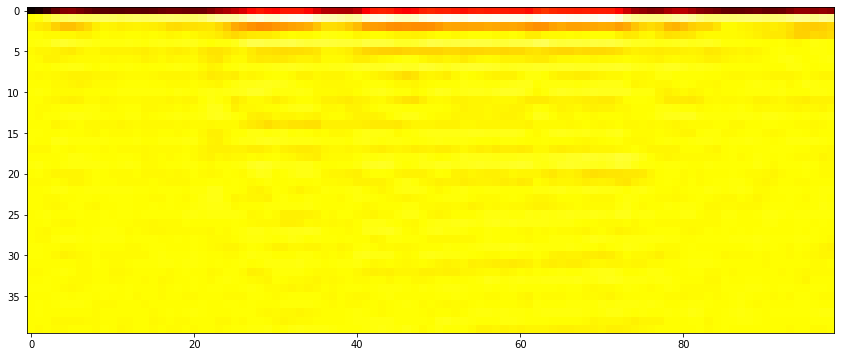

In [23]:
mfcc = get_mfcc(file, n_mfcc=40, padding=40)
print(mfcc.shape)
plt.figure(figsize=(18,6))
plt.imshow(mfcc, cmap='hot');

Let's see how much padding we need for the longest file

In [24]:
print(get_mfcc(train.sort_values('length').fname.iloc[-1]).shape)

(128, 173)


In [25]:
train.sort_values('length').fname.iloc[-1]

'B_BRI01_MC_FI_SIM01_202.wav'

Text(0.5, 1.0, 'The longest file')

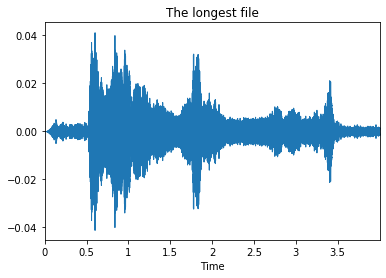

In [26]:
y, sr = librosa.load('./dataset/B_BRI01_MC_FI_SIM01_202.wav')
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('The longest file')

In [27]:
from functools import partial

n_mfcc = 128
padding = 173
fun = partial(get_mfcc, n_mfcc=n_mfcc, padding=padding)

with Parallel(n_jobs=10, verbose=1) as ex:
    mfcc_data = ex(delayed(partial(fun))(e) for e in train.fname)
    
# Juntamos la data en un solo array y agregamos una dimension
mfcc_data = np.stack(mfcc_data)[..., None]
mfcc_data.shape

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.2s
[Parallel(n_jobs=10)]: Done 271 tasks      | elapsed:   18.4s
[Parallel(n_jobs=10)]: Done 421 out of 440 | elapsed:   19.6s remaining:    0.8s
[Parallel(n_jobs=10)]: Done 440 out of 440 | elapsed:   19.7s finished


(440, 128, 173, 1)

## 3.2 Categories
Naming conventions follow the pattern C_NNNNN_BB_SS_OOOOO_RXX, which has to be exploded as follows:
* NNNNN = cat’s unique ID;
* BB = breed (values: MC = Maine Coon; EU: European Shorthair);
* SS = sex (values: FI = female, intact; FN: female, neutered; MI: male, intact; MN: male, neutered);
* OOOOO = cat owner’s unique ID;
* R = recording session (values: 1, 2 or 3)
* XX = vocalization counter (values: 01..99)

In [28]:
train.head()

,fname,length
0,B_ANI01_MC_FN_SIM01_101.wav,2.281500
1,B_ANI01_MC_FN_SIM01_102.wav,1.419000
2,B_ANI01_MC_FN_SIM01_103.wav,1.798875
3,B_ANI01_MC_FN_SIM01_301.wav,1.739500
4,B_ANI01_MC_FN_SIM01_302.wav,1.268000


In [29]:
for i in range(5):
    print('B_ANI01_MC_FN_SIM01_101.wav'.split('_')[i])

B
ANI01
MC
FN
SIM01


In [31]:
title = ['emission_context','cat_id','breed','sex','cat_owner_id','recording_session_and_vocalization_counter']

for j in range(len(title)):
    label_list = []
    for i in train['fname']:
        #print(j)
        label_list.append(i.split('_')[j])
    train[title[j]] = label_list
    
train.head(3)

,fname,length,emission_context,cat_id,breed,sex,cat_owner_id,recording_session_and_vocalization_counter
0,B_ANI01_MC_FN_SIM01_101.wav,2.281500,B,ANI01,MC,FN,SIM01,101.wav
1,B_ANI01_MC_FN_SIM01_102.wav,1.419000,B,ANI01,MC,FN,SIM01,102.wav
2,B_ANI01_MC_FN_SIM01_103.wav,1.798875,B,ANI01,MC,FN,SIM01,103.wav


In [32]:
lbl2idx = {lbl:idx for idx,lbl in enumerate(train.breed.unique())}
idx2lbl = {idx:lbl for lbl,idx in lbl2idx.items()}
n_categories = len(lbl2idx)

In [33]:
lbl2idx

{'MC': 0, 'EU': 1}

In [34]:
idx2lbl

{0: 'MC', 1: 'EU'}

In [35]:
n_categories = len(lbl2idx)

In [36]:
train['y'] = train.breed.map(lbl2idx)
train.head()

,fname,length,emission_context,cat_id,breed,sex,cat_owner_id,recording_session_and_vocalization_counter,y
0,B_ANI01_MC_FN_SIM01_101.wav,2.281500,B,ANI01,MC,FN,SIM01,101.wav,0
1,B_ANI01_MC_FN_SIM01_102.wav,1.419000,B,ANI01,MC,FN,SIM01,102.wav,0
2,B_ANI01_MC_FN_SIM01_103.wav,1.798875,B,ANI01,MC,FN,SIM01,103.wav,0
3,B_ANI01_MC_FN_SIM01_301.wav,1.739500,B,ANI01,MC,FN,SIM01,301.wav,0
4,B_ANI01_MC_FN_SIM01_302.wav,1.268000,B,ANI01,MC,FN,SIM01,302.wav,0


## 3.3 Data Preprocess for tensorflow

In [37]:
Ytrain = np.array(train['y'])
Ytrain=Ytrain.reshape(Ytrain.shape[0],1)
Ytrain.shape

(440, 1)

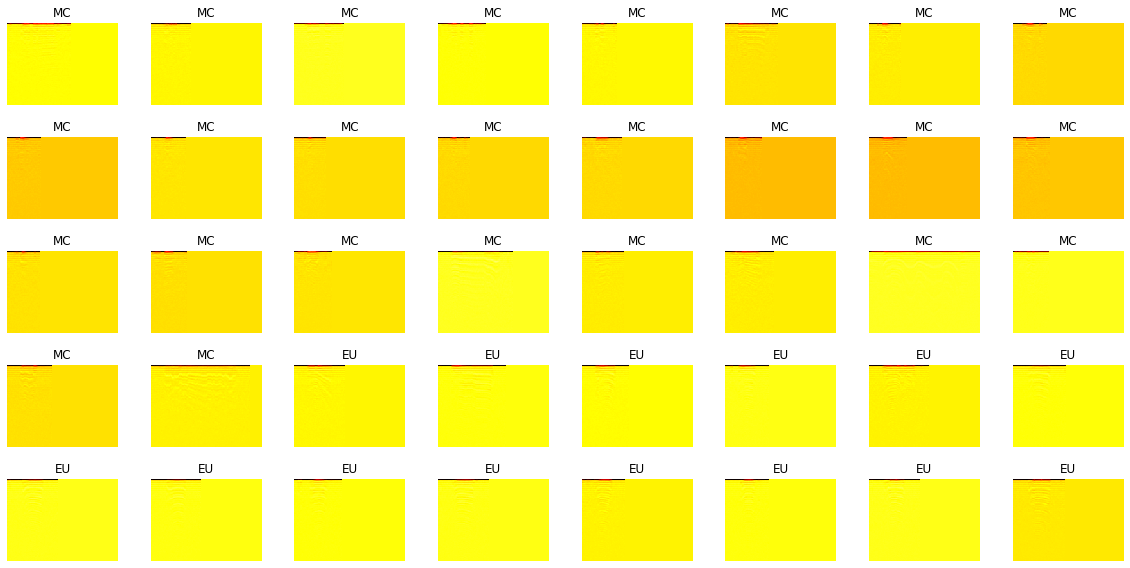

In [38]:
# dict
dictionary=idx2lbl
# visualizing training samples
plt.figure(figsize=(20,10))
for i in range(40):  
    plt.subplot(5, 8, i+1)
    plt.imshow(mfcc_data[i].reshape((mfcc_data[i].shape[0], mfcc_data[i].shape[1])),cmap='hot')
    plt.title(dictionary[Ytrain[i][0]])
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [43]:
# change data type to float32
mfcc_data.astype('float32')
# Normalize pixel values to be between 0 and 1
mfcc_data = mfcc_data-mfcc_data.min() / (mfcc_data.max()-mfcc_data.min())

In [44]:
# Encoding
Ytrain = to_categorical(np.array(Ytrain[:, 0]))

In [45]:
Ytrain.shape

(440, 2)

## 3.4 Train validation split

In [46]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(mfcc_data, Ytrain, test_size=0.2, random_state=42)
x_train.shape, x_val.shape

((352, 128, 173, 1), (88, 128, 173, 1))

In [47]:
inputs = np.zeros((1, x_train.shape[1], x_train.shape[2], x_train.shape[3]), dtype=np.float32)
inputs.shape

(1, 128, 173, 1)

# 4. Model Design: Meow-Net
## 4.1 Meow-Attention Block

In [59]:
def Meow_Attention_Block(inputs, filters, ratio):
    x = inputs
    x1 = Conv2D(1, (1, 1), strides=(1, 1), padding='same', use_bias=False, activation=None)(x)
    self_attention = Activation('softmax')(x1)
    x = x * self_attention
    x = Reshape((1, 1, int(x.shape[1])))(x)
    x = Conv2D(int(filters / ratio), (1, 1), strides=(1, 1), padding='same', use_bias=False, activation=None)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(filters), (1, 1), strides=(1, 1), padding='same', use_bias=False, activation=None)(x)
    excitation = Activation('hard_sigmoid')(x)
    x = inputs * excitation
    return x

## 4.2 Meow-Proliferate Block

In [60]:
def Meow_Proliferate_Block(inputs, out, ratio, convkernel, dwkernel):
    x = inputs
    conv_out_channel = ceil(out * 1.0 / ratio)
    x = Conv2D(int(conv_out_channel), (convkernel, convkernel), use_bias=False,
               strides=(1, 1), padding='same', activation=None)(x)
    if ratio == 1:
        return x
    else:
        dw = DepthwiseConv2D(dwkernel, 1, padding='same', use_bias=False,
                            depth_multiplier=ratio-1, activation=None)(x)
        dw = dw[:, :, :, :int(out - conv_out_channel)]
        output = Concatenate()([x, dw])
        return output

## 4.3 Meow-Proliferate-and-Attention Block

In [61]:
def Meow_Proliferate_and_Attention_Block(inputs, dwkernel, strides, exp, out, ratio, use_sa):
    x = DepthwiseConv2D(dwkernel, strides, padding='same', depth_multiplier=ratio-1,
                        activation=None, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(out, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization()(x)
    y = Meow_Proliferate_Block(inputs, exp, ratio, 1, 3) # inputs, out, ratio(s=2, 50%), convkernel(k=1), dwkernel(d=3)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    if strides > 1:
        y = DepthwiseConv2D(dwkernel, strides, padding='same', depth_multiplier=ratio-1, 
                            activation=None, use_bias=False)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
    if use_sa:
        Meow_Attention_Block(y, exp, ratio)
    y = Meow_Proliferate_Block(y, out, ratio, 1, 3)
    y = BatchNormalization()(y)
    return add([x, y])

## 4.4 Meow-Net

In [62]:
def Meow_Proliferate_And_Attention_Network(classes):

    img_input = keras.layers.Input(shape=(128, 173, 1))
    x = Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation=None, use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for i in range(16):
        x = Meow_Proliferate_and_Attention_Block(x, dwkernels[i], strides[i], exps[i], outs[i], ratios[i], use_sa[i])
        
    x = Conv2D(960, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, int(x.shape[1])))(x)
    
    x = Conv2D(1280, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(classes, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = tf.squeeze(x, 1)
    x = tf.squeeze(x, 1)
    output = Activation('softmax')(x)
    
    model = tf.keras.Model(img_input, output)
    return model

## 4.5 Cosine LR Annearling

In [52]:
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [53]:
# Hyperparamaters
dwkernels = [3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5]
strides = [1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]
exps = [16, 48, 72, 72, 120, 240, 200, 184, 184, 480, 672, 672, 960, 960, 960, 960]
outs = [16, 24, 24, 40, 40, 80, 80, 80, 80, 112, 112, 160, 160, 160, 160, 160]
ratios = [2] * 16
use_sa = [False, False, False, True, True, False, False, False,
           False, True, True, True, False, True, False, True]

# 5. Model Training (Meow~)

In [54]:
model = Meow_Proliferate_And_Attention_Network(classes=2)
model.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 173, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 87, 16)   144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 87, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 87, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
depthwise_conv2d_15 (DepthwiseC (None, 16, 22, 60)   540         conv2d_17[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_strided_slice_8 (Te [(None, 16, 22, 60)] 0           depthwise_conv2d_15[0][0]        
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 16, 22, 120)  0           conv2d_17[0][0]                  
                                                                 tf_op_layer_strided_slice_8[0][0]
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 16, 22, 120)  480         concatenate_8[0][0]              
__________________________________________________________________________________________________
activation

batch_normalization_36 (BatchNo (None, 8, 11, 80)    320         depthwise_conv2d_27[0][0]        
__________________________________________________________________________________________________
tf_op_layer_strided_slice_17 (T [(None, 8, 11, 40)]  0           depthwise_conv2d_29[0][0]        
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 8, 11, 80)    6400        batch_normalization_36[0][0]     
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 8, 11, 80)    0           conv2d_33[0][0]                  
                                                                 tf_op_layer_strided_slice_17[0][0
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 8, 11, 80)    320         conv2d_31[0][0]                  
__________

depthwise_conv2d_44 (DepthwiseC (None, 4, 6, 480)    4320        conv2d_56[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_strided_slice_26 (T [(None, 4, 6, 480)]  0           depthwise_conv2d_44[0][0]        
__________________________________________________________________________________________________
concatenate_26 (Concatenate)    (None, 4, 6, 960)    0           conv2d_56[0][0]                  
                                                                 tf_op_layer_strided_slice_26[0][0
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 4, 6, 960)    3840        concatenate_26[0][0]             
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 4, 6, 960)    0           batch_normalization_59[0][0]     
__________

In [91]:
callbacks = [CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)]
log = model.fit(x_train, y_train, bs, 20, validation_split=0.25,callbacks=callbacks)

Train on 264 samples, validate on 88 samples
Epoch 1/20
264/264 [==============================] - ETA: 27s - loss: 1.8790 - accuracy: 0.600 - ETA: 14s - loss: 2.8969 - accuracy: 0.500 - ETA: 9s - loss: 2.5765 - accuracy: 0.533 - ETA: 7s - loss: 2.5441 - accuracy: 0.45 - ETA: 6s - loss: 2.6339 - accuracy: 0.46 - ETA: 5s - loss: 2.4635 - accuracy: 0.45 - ETA: 4s - loss: 2.5417 - accuracy: 0.45 - ETA: 3s - loss: 2.6077 - accuracy: 0.46 - ETA: 3s - loss: 2.4456 - accuracy: 0.46 - ETA: 3s - loss: 2.2713 - accuracy: 0.48 - ETA: 2s - loss: 2.2690 - accuracy: 0.48 - ETA: 2s - loss: 2.2471 - accuracy: 0.49 - ETA: 2s - loss: 2.1813 - accuracy: 0.51 - ETA: 1s - loss: 2.0900 - accuracy: 0.53 - ETA: 1s - loss: 2.1245 - accuracy: 0.52 - ETA: 1s - loss: 2.1050 - accuracy: 0.53 - ETA: 1s - loss: 2.1562 - accuracy: 0.53 - ETA: 1s - loss: 2.2464 - accuracy: 0.53 - ETA: 1s - loss: 2.1586 - accuracy: 0.55 - ETA: 0s - loss: 2.0971 - accuracy: 0.55 - ETA: 0s - loss: 2.1410 - accuracy: 0.54 - ETA: 0s - loss

264/264 [==============================] - ETA: 2s - loss: 0.1938 - accuracy: 0.90 - ETA: 2s - loss: 0.1164 - accuracy: 0.95 - ETA: 2s - loss: 0.6722 - accuracy: 0.83 - ETA: 2s - loss: 0.5496 - accuracy: 0.85 - ETA: 2s - loss: 0.5013 - accuracy: 0.84 - ETA: 2s - loss: 0.4289 - accuracy: 0.86 - ETA: 2s - loss: 0.3941 - accuracy: 0.87 - ETA: 1s - loss: 0.3700 - accuracy: 0.87 - ETA: 1s - loss: 0.4191 - accuracy: 0.86 - ETA: 1s - loss: 0.3828 - accuracy: 0.88 - ETA: 1s - loss: 0.3842 - accuracy: 0.88 - ETA: 1s - loss: 0.3539 - accuracy: 0.89 - ETA: 1s - loss: 0.3344 - accuracy: 0.90 - ETA: 1s - loss: 0.3976 - accuracy: 0.89 - ETA: 1s - loss: 0.4105 - accuracy: 0.89 - ETA: 1s - loss: 0.4086 - accuracy: 0.89 - ETA: 0s - loss: 0.3866 - accuracy: 0.90 - ETA: 0s - loss: 0.3726 - accuracy: 0.90 - ETA: 0s - loss: 0.3710 - accuracy: 0.89 - ETA: 0s - loss: 0.3567 - accuracy: 0.90 - ETA: 0s - loss: 0.3681 - accuracy: 0.89 - ETA: 0s - loss: 0.4215 - accuracy: 0.88 - ETA: 0s - loss: 0.4261 - accuracy

# 6. Training Result

In [92]:
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [], [], [], []
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
        trn_acc += log.history['accuracy']
        val_acc += log.history['val_accuracy']
    
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(trn_loss, label='train')
    ax1.plot(val_loss, label='validation')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(trn_acc, label='train')
    ax2.plot(val_acc, label='validation')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax,title in zip(axes, ['Train', 'Accuracy']):
        ax.set_title(title, size=14)
        ax.legend()

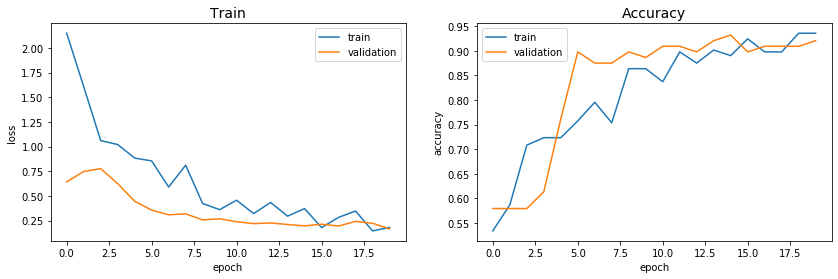

In [93]:
show_results(log)

# 7. Test Result

In [124]:
model.evaluate(x_val, y_val)
# loss, Accuracy

88/88 [==============================] - ETA:  - 0s 1ms/step


[0.7584973140196367, 0.8522727489471436]

### 7.1 Label to Arrary

In [114]:
# Label to Arrary
y_test=y_val.values
y_test

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
      dtype=int64)

### 7.2 Prediction to List

In [96]:
prediction = model.predict(x_val)

In [110]:
prediction.shape

(88, 2)

In [112]:
result=[]
for i in range(prediction.shape[0]):
    if(prediction[i][0]>prediction[i][1]):
        result.append(0)
    if(prediction[i][0]<=prediction[i][1]):
        result.append(1)        

### 7.3 Performance Function

In [119]:
list = []
for i in range(y_test.shape[0]):
    list.append(y_test[i])

In [122]:
# Performance function
def performance_model(result,y_test):
    # Get Label in array
    list = []
    for i in range(y_test.shape[0]):
        list.append(y_test[i])
    
    # TN: True Nagetive, TP: True Positive, FP: False Positive, FN: False Nagetive
    i = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    while i < len(y_test):
        if result[i] == list[i]:
            if result[i] == 0:
                TN += 1
            else:
                TP += 1
        else:
            if result[i] == 1:
                FP += 1
            else:
                FN += 1
        i += 1
        
    #  Accuracy (ACC), precision (PR), recall (RC),and F-score(FS)
    ACC = (TN+TP)/(TN+TP+FP+FN)
    PR = TP/(TP+FP)
    RC = TP/(TP+FN)
    FS = 2*(PR*RC)/(PR+RC)
    
    return(ACC,PR,RC,FS)

In [123]:
#X_train, X_test, y_train, y_test
ACC,PR,RC,FS = performance_model(result,y_test)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)

Accuracy:  0.8522727272727273
Precision: 0.8181818181818182
Recall:  0.8780487804878049
F-score:  0.8470588235294119


# Emission Context Prediction

In [55]:
lbl2idx = {lbl:idx for idx,lbl in enumerate(train.emission_context.unique())}
idx2lbl = {idx:lbl for lbl,idx in lbl2idx.items()}
n_categories = len(lbl2idx)

n_categories = len(lbl2idx)
train['y2'] = train.emission_context.map(lbl2idx)
train.head()

,fname,length,emission_context,cat_id,breed,sex,cat_owner_id,recording_session_and_vocalization_counter,y,y2
0,B_ANI01_MC_FN_SIM01_101.wav,2.281500,B,ANI01,MC,FN,SIM01,101.wav,0,0
1,B_ANI01_MC_FN_SIM01_102.wav,1.419000,B,ANI01,MC,FN,SIM01,102.wav,0,0
2,B_ANI01_MC_FN_SIM01_103.wav,1.798875,B,ANI01,MC,FN,SIM01,103.wav,0,0
3,B_ANI01_MC_FN_SIM01_301.wav,1.739500,B,ANI01,MC,FN,SIM01,301.wav,0,0
4,B_ANI01_MC_FN_SIM01_302.wav,1.268000,B,ANI01,MC,FN,SIM01,302.wav,0,0


In [56]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(mfcc_data, train.y2, test_size=0.2, random_state=42)

model2 = Meow_Proliferate_And_Attention_Network(classes=2)
model2.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])
#model2.summary()

In [143]:
callbacks = [CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)]
log2 = model2.fit(x_train, y_train, bs, 20, validation_split=0.25,callbacks=callbacks)

Train on 264 samples, validate on 88 samples
Epoch 1/20
264/264 [==============================] - ETA: 25s - loss: 5.1326 - accuracy: 0.300 - ETA: 13s - loss: 5.0208 - accuracy: 0.250 - ETA: 9s - loss: 4.2348 - accuracy: 0.266 - ETA: 6s - loss: 4.0406 - accuracy: 0.25 - ETA: 5s - loss: 3.8988 - accuracy: 0.26 - ETA: 4s - loss: 3.6495 - accuracy: 0.28 - ETA: 4s - loss: 3.5247 - accuracy: 0.30 - ETA: 3s - loss: 3.5667 - accuracy: 0.28 - ETA: 3s - loss: 3.2824 - accuracy: 0.33 - ETA: 2s - loss: 3.1918 - accuracy: 0.31 - ETA: 2s - loss: 3.0760 - accuracy: 0.30 - ETA: 2s - loss: 3.1315 - accuracy: 0.32 - ETA: 2s - loss: 2.9924 - accuracy: 0.36 - ETA: 1s - loss: 2.9049 - accuracy: 0.37 - ETA: 1s - loss: 2.9096 - accuracy: 0.38 - ETA: 1s - loss: 3.0565 - accuracy: 0.37 - ETA: 1s - loss: 3.0108 - accuracy: 0.38 - ETA: 1s - loss: 2.9601 - accuracy: 0.38 - ETA: 1s - loss: 2.9406 - accuracy: 0.39 - ETA: 0s - loss: 2.8777 - accuracy: 0.40 - ETA: 0s - loss: 2.8205 - accuracy: 0.40 - ETA: 0s - loss

264/264 [==============================] - ETA: 1s - loss: 0.6233 - accuracy: 0.70 - ETA: 1s - loss: 1.0317 - accuracy: 0.70 - ETA: 1s - loss: 1.6548 - accuracy: 0.60 - ETA: 1s - loss: 1.3916 - accuracy: 0.62 - ETA: 1s - loss: 1.1858 - accuracy: 0.66 - ETA: 1s - loss: 1.2023 - accuracy: 0.65 - ETA: 1s - loss: 1.1002 - accuracy: 0.67 - ETA: 1s - loss: 1.0816 - accuracy: 0.68 - ETA: 1s - loss: 0.9882 - accuracy: 0.71 - ETA: 1s - loss: 0.9006 - accuracy: 0.74 - ETA: 1s - loss: 0.8971 - accuracy: 0.73 - ETA: 1s - loss: 0.8371 - accuracy: 0.75 - ETA: 1s - loss: 0.8024 - accuracy: 0.76 - ETA: 0s - loss: 0.8717 - accuracy: 0.74 - ETA: 0s - loss: 0.8707 - accuracy: 0.74 - ETA: 0s - loss: 0.8846 - accuracy: 0.75 - ETA: 0s - loss: 0.8981 - accuracy: 0.74 - ETA: 0s - loss: 0.8970 - accuracy: 0.74 - ETA: 0s - loss: 0.8741 - accuracy: 0.74 - ETA: 0s - loss: 0.9183 - accuracy: 0.73 - ETA: 0s - loss: 0.9090 - accuracy: 0.74 - ETA: 0s - loss: 0.9125 - accuracy: 0.73 - ETA: 0s - loss: 0.8746 - accuracy

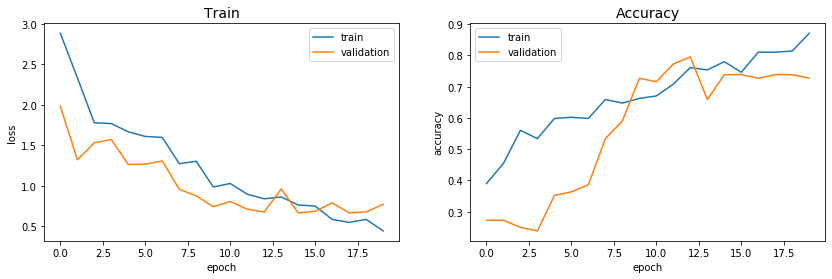

In [144]:
show_results(log2)

In [145]:
model2.evaluate(x_val, y_val)

88/88 [==============================] - ETA:  - ETA:  - 0s 2ms/step


[1.422018137845126, 0.5340909361839294]

# Sex Prediction

In [57]:
lbl2idx = {lbl:idx for idx,lbl in enumerate(train.sex.unique())}
idx2lbl = {idx:lbl for lbl,idx in lbl2idx.items()}
n_categories = len(lbl2idx)

n_categories = len(lbl2idx)
train['y3'] = train.sex.map(lbl2idx)
train.head()

,fname,length,emission_context,cat_id,breed,sex,cat_owner_id,recording_session_and_vocalization_counter,y,y2,y3
0,B_ANI01_MC_FN_SIM01_101.wav,2.281500,B,ANI01,MC,FN,SIM01,101.wav,0,0,0
1,B_ANI01_MC_FN_SIM01_102.wav,1.419000,B,ANI01,MC,FN,SIM01,102.wav,0,0,0
2,B_ANI01_MC_FN_SIM01_103.wav,1.798875,B,ANI01,MC,FN,SIM01,103.wav,0,0,0
3,B_ANI01_MC_FN_SIM01_301.wav,1.739500,B,ANI01,MC,FN,SIM01,301.wav,0,0,0
4,B_ANI01_MC_FN_SIM01_302.wav,1.268000,B,ANI01,MC,FN,SIM01,302.wav,0,0,0


In [58]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(mfcc_data, train.y2, test_size=0.2, random_state=42)

model3 = Meow_Proliferate_And_Attention_Network(classes=2)
model3.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])
#model3.summary()

In [147]:
callbacks = [CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)]
log3 = model3.fit(x_train, y_train, bs, 20, validation_split=0.25,callbacks=callbacks)

Train on 264 samples, validate on 88 samples
Epoch 1/20
264/264 [==============================] - ETA: 24s - loss: 11.3782 - accuracy: 0.10 - ETA: 12s - loss: 8.7934 - accuracy: 0.0500 - ETA: 8s - loss: 7.0870 - accuracy: 0.100 - ETA: 6s - loss: 6.5207 - accuracy: 0.15 - ETA: 5s - loss: 6.2233 - accuracy: 0.16 - ETA: 4s - loss: 5.3809 - accuracy: 0.21 - ETA: 3s - loss: 4.7934 - accuracy: 0.30 - ETA: 3s - loss: 4.4705 - accuracy: 0.36 - ETA: 2s - loss: 4.3226 - accuracy: 0.40 - ETA: 2s - loss: 4.0724 - accuracy: 0.43 - ETA: 2s - loss: 4.3163 - accuracy: 0.41 - ETA: 2s - loss: 4.2680 - accuracy: 0.41 - ETA: 1s - loss: 4.2377 - accuracy: 0.43 - ETA: 1s - loss: 4.3643 - accuracy: 0.42 - ETA: 1s - loss: 4.4378 - accuracy: 0.42 - ETA: 1s - loss: 4.4545 - accuracy: 0.41 - ETA: 1s - loss: 4.2503 - accuracy: 0.43 - ETA: 0s - loss: 4.0599 - accuracy: 0.43 - ETA: 0s - loss: 3.9894 - accuracy: 0.43 - ETA: 0s - loss: 3.8598 - accuracy: 0.45 - ETA: 0s - loss: 3.7864 - accuracy: 0.45 - ETA: 0s - los

264/264 [==============================] - ETA: 1s - loss: 0.6802 - accuracy: 0.80 - ETA: 1s - loss: 0.6110 - accuracy: 0.75 - ETA: 1s - loss: 0.6737 - accuracy: 0.70 - ETA: 1s - loss: 0.7192 - accuracy: 0.70 - ETA: 1s - loss: 0.6850 - accuracy: 0.72 - ETA: 1s - loss: 0.7860 - accuracy: 0.71 - ETA: 1s - loss: 0.8548 - accuracy: 0.72 - ETA: 1s - loss: 0.8056 - accuracy: 0.73 - ETA: 1s - loss: 0.7507 - accuracy: 0.75 - ETA: 1s - loss: 0.7007 - accuracy: 0.77 - ETA: 1s - loss: 0.7049 - accuracy: 0.77 - ETA: 1s - loss: 0.6967 - accuracy: 0.77 - ETA: 0s - loss: 0.6992 - accuracy: 0.77 - ETA: 0s - loss: 0.7279 - accuracy: 0.77 - ETA: 0s - loss: 0.7303 - accuracy: 0.77 - ETA: 0s - loss: 0.7315 - accuracy: 0.76 - ETA: 0s - loss: 0.7156 - accuracy: 0.76 - ETA: 0s - loss: 0.7461 - accuracy: 0.76 - ETA: 0s - loss: 0.7532 - accuracy: 0.76 - ETA: 0s - loss: 0.7535 - accuracy: 0.77 - ETA: 0s - loss: 0.7474 - accuracy: 0.77 - ETA: 0s - loss: 0.7698 - accuracy: 0.76 - ETA: 0s - loss: 0.7579 - accuracy

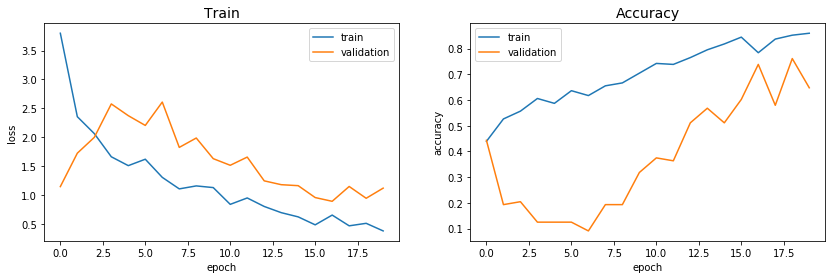

In [148]:
show_results(log3)

In [149]:
model3.evaluate(x_val, y_val)

88/88 [==============================] - ETA:  - ETA:  - 0s 2ms/step


[1.2987762256102129, 0.6477272510528564]

# Conclusion
From the experiment results, we have the opportunity to learn the breed, gender, and environment of the cat through the cat's vocalizations.
* The performance of this model for cat **breed** prediction is ok (Acc: 85.22%, base line = 1/2 = 50%).
* The prediction accuracy of the **environment** is slightly higher than the baseline (Acc: 53.41%, base line = 1/3 = 33.3%).
* The prediction of **gender/ligation** is higher than the baseline (Acc: 64.77%, base line = 1/4 = 25%).